# Load TraCE data
Ref He et al., 2011

In [1]:
import xarray as xr

path='D:/VScode/Last_deglaciation/TraCE_data/'
trace_orb = xr.open_dataset(path + 'b30.00_4kaDVTj.cam2.ncrcat.ann.nc')
trace_allforcing_sat = xr.open_dataset(path+'trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')
trace_allforcing_sic=xr.open_dataset(path+'trace.01-36.22000BP.cam2.ICEFRAC.22000BP_decavg_400BCE.nc')


trace_orb = trace_orb.rename({'TREFHT': 'sat'})
trace_orb = trace_orb.rename({'time': 'age'})
trace_orb['age'] = trace_orb['age'] * -1000
trace_orb['sat'] = trace_orb['sat'] - 273.15 # convert to Celsius

trace_orb_sat = trace_orb[['sat']]
trace_orb_sic = trace_orb[['ICEFRAC']]


trace_allforcing_sat = trace_allforcing_sat.rename({'TREFHT': 'sat'})
trace_allforcing_sat = trace_allforcing_sat.rename({'time': 'age'})
trace_allforcing_sat['age'] = trace_allforcing_sat['age'] * -1000
trace_allforcing_sat['sat'] = trace_allforcing_sat['sat'] - 273.15
trace_allforcing_sat = trace_allforcing_sat[['sat']]


trace_allforcing_sic = trace_allforcing_sic.rename({'time': 'age'})
trace_allforcing_sic['age'] = trace_allforcing_sic['age'] * -1000
trace_allforcing_sic = trace_allforcing_sic[['ICEFRAC']]


# Calculate sea ice area forTraCE

In [2]:
import xarray as xr
import numpy as np
import pickle

def calculate_seaice_area(ds_seaice, variable_name='sic',lat_min=-90,lat_max=0):    
    # Subset dataset for latitude from -90 to 0
    ds_seaice_subset = ds_seaice.sel(lat=slice(lat_min, lat_max))

    # Constants
    R = 6371  # Earth's radius in km
    delta_theta = 2.5 / 180 * np.pi  # 2.5 degree in radians

    # Convert latitude values to radians and compute latitudinal boundaries
    lat_radians = np.radians(ds_seaice_subset['lat'].values)
    lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2

    # area of each grid, 
    # Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
    A = R**2 * delta_theta * (np.sin(lat_boundaries[1:]) - np.sin(lat_boundaries[:-1]))
    A_center_lats = ds_seaice_subset['lat'].values[1:-1]

    # Reduce dataset size
    ds_seaice_subset_reduced = ds_seaice_subset.isel(lat=slice(1, -1))

    # Create an xarray DataArray for A
    A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

    # Multiply sic data with A
    sic = ds_seaice_subset_reduced[variable_name]
    sic_area = sic * A_xr

    # Sum up the resulting product
    LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values / 1e6
    # print('LGMR_sic_area:', LGMR_sic_area.shape)

    # Add age to LGMR_sic_area
    LGMR_sic_area = np.column_stack((ds_seaice_subset_reduced['age'].values, LGMR_sic_area))

    return LGMR_sic_area


In [3]:
asice_trace_orb_sh = calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_allforcing_sh = calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)

asice_trace_orb_nh = calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC', lat_min=0, lat_max=90)
asice_trace_allforcing_nh = calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC', lat_min=0, lat_max=90)

In [6]:
# save the data to 'D:\VScode\Last_deglaciation\TraCE_data'
with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_orb_sh.pkl', 'wb') as f:
    pickle.dump(asice_trace_orb_sh, f)  
with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_allforcing_sh.pkl', 'wb') as f:
    pickle.dump(asice_trace_allforcing_sh, f)

with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_orb_nh.pkl', 'wb') as f:
    pickle.dump(asice_trace_orb_nh, f)
with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_allforcing_nh.pkl', 'wb') as f:
    pickle.dump(asice_trace_allforcing_nh, f)

# Processes the EBM sea ice data

In [12]:
# read the /data_fig3/EMB_results.xlsx
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
filename='EBM_results_shorten_Jan31.xlsx'

df_full_orbital_EBM_sh=pd.read_excel(path+filename, sheet_name='Full-orbital')
# the first column*1000
df_full_orbital_EBM_sh['age']=df_full_orbital_EBM_sh['age']*1000
# save the df_full_orbital to csv
df_full_orbital_EBM_sh.to_csv(path+'df_full_orbital_EBM_sh.csv', index=False)
df_full_orbital_EBM_sh.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,427.336750,5.564279,-1.029714,23.891422,NaN,NaN
1,11000,428.465963,5.557092,-1.058631,24.010389,NaN,NaN
2,12000,430.701655,5.551410,-1.096506,24.172172,NaN,NaN
3,13000,433.812557,5.542759,-1.128241,24.309235,NaN,NaN
4,14000,437.481913,5.532736,-1.161961,24.439776,NaN,NaN


In [13]:
# read the /data_fig3/EMB_results.xlsx
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
filename='EBM_results_shorten_Jan31_nh.xlsx'

df_full_orbital_EBM_nh=pd.read_excel(path+filename, sheet_name='Full-orbital')
# the first column*1000
df_full_orbital_EBM_nh['age']=df_full_orbital_EBM_nh['age']*1000
# save the df_full_orbital to csv
df_full_orbital_EBM_nh.to_csv(path+'df_full_orbital_EBM_nh.csv', index=False)
df_full_orbital_EBM_nh.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,427.336750,5.564279,-0.894284,23.379340,NaN,NaN
1,11000,428.465963,5.557092,-0.886673,23.333497,NaN,NaN
2,12000,430.701655,5.551410,-0.890315,23.324402,NaN,NaN
3,13000,433.812557,5.542759,-0.919701,23.417618,NaN,NaN
4,14000,437.481913,5.532736,-0.964046,23.576391,NaN,NaN


# Load processed data

In [16]:
# read the TraCE data
with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_orb_sh.pkl', 'rb') as f:
    asice_trace_orb_sh = pickle.load(f)
with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_allforcing_sh.pkl', 'rb') as f:
    asice_trace_allforcing_sh = pickle.load(f)

with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_orb_nh.pkl', 'rb') as f:
    asice_trace_orb_nh = pickle.load(f)
with open('D:/VScode/Last_deglaciation/TraCE_data/asice_trace_allforcing_nh.pkl', 'rb') as f:
    asice_trace_allforcing_nh = pickle.load(f)

# read the EBM data
path='D:/VScode/Last_deglaciation/EBM_data/'
df_full_orbital_EBM_sh=pd.read_csv(path+'df_full_orbital_EBM_sh.csv')
df_full_orbital_EBM_nh=pd.read_csv(path+'df_full_orbital_EBM_nh.csv')
# df_full_orbital_EBM_nh.head()
# df_full_orbital_EBM_sh.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,427.336750,5.564279,-1.029714,23.891422,NaN,NaN
1,11000,428.465963,5.557092,-1.058631,24.010389,NaN,NaN
2,12000,430.701655,5.551410,-1.096506,24.172172,NaN,NaN
3,13000,433.812557,5.542759,-1.128241,24.309235,NaN,NaN
4,14000,437.481913,5.532736,-1.161961,24.439776,NaN,NaN


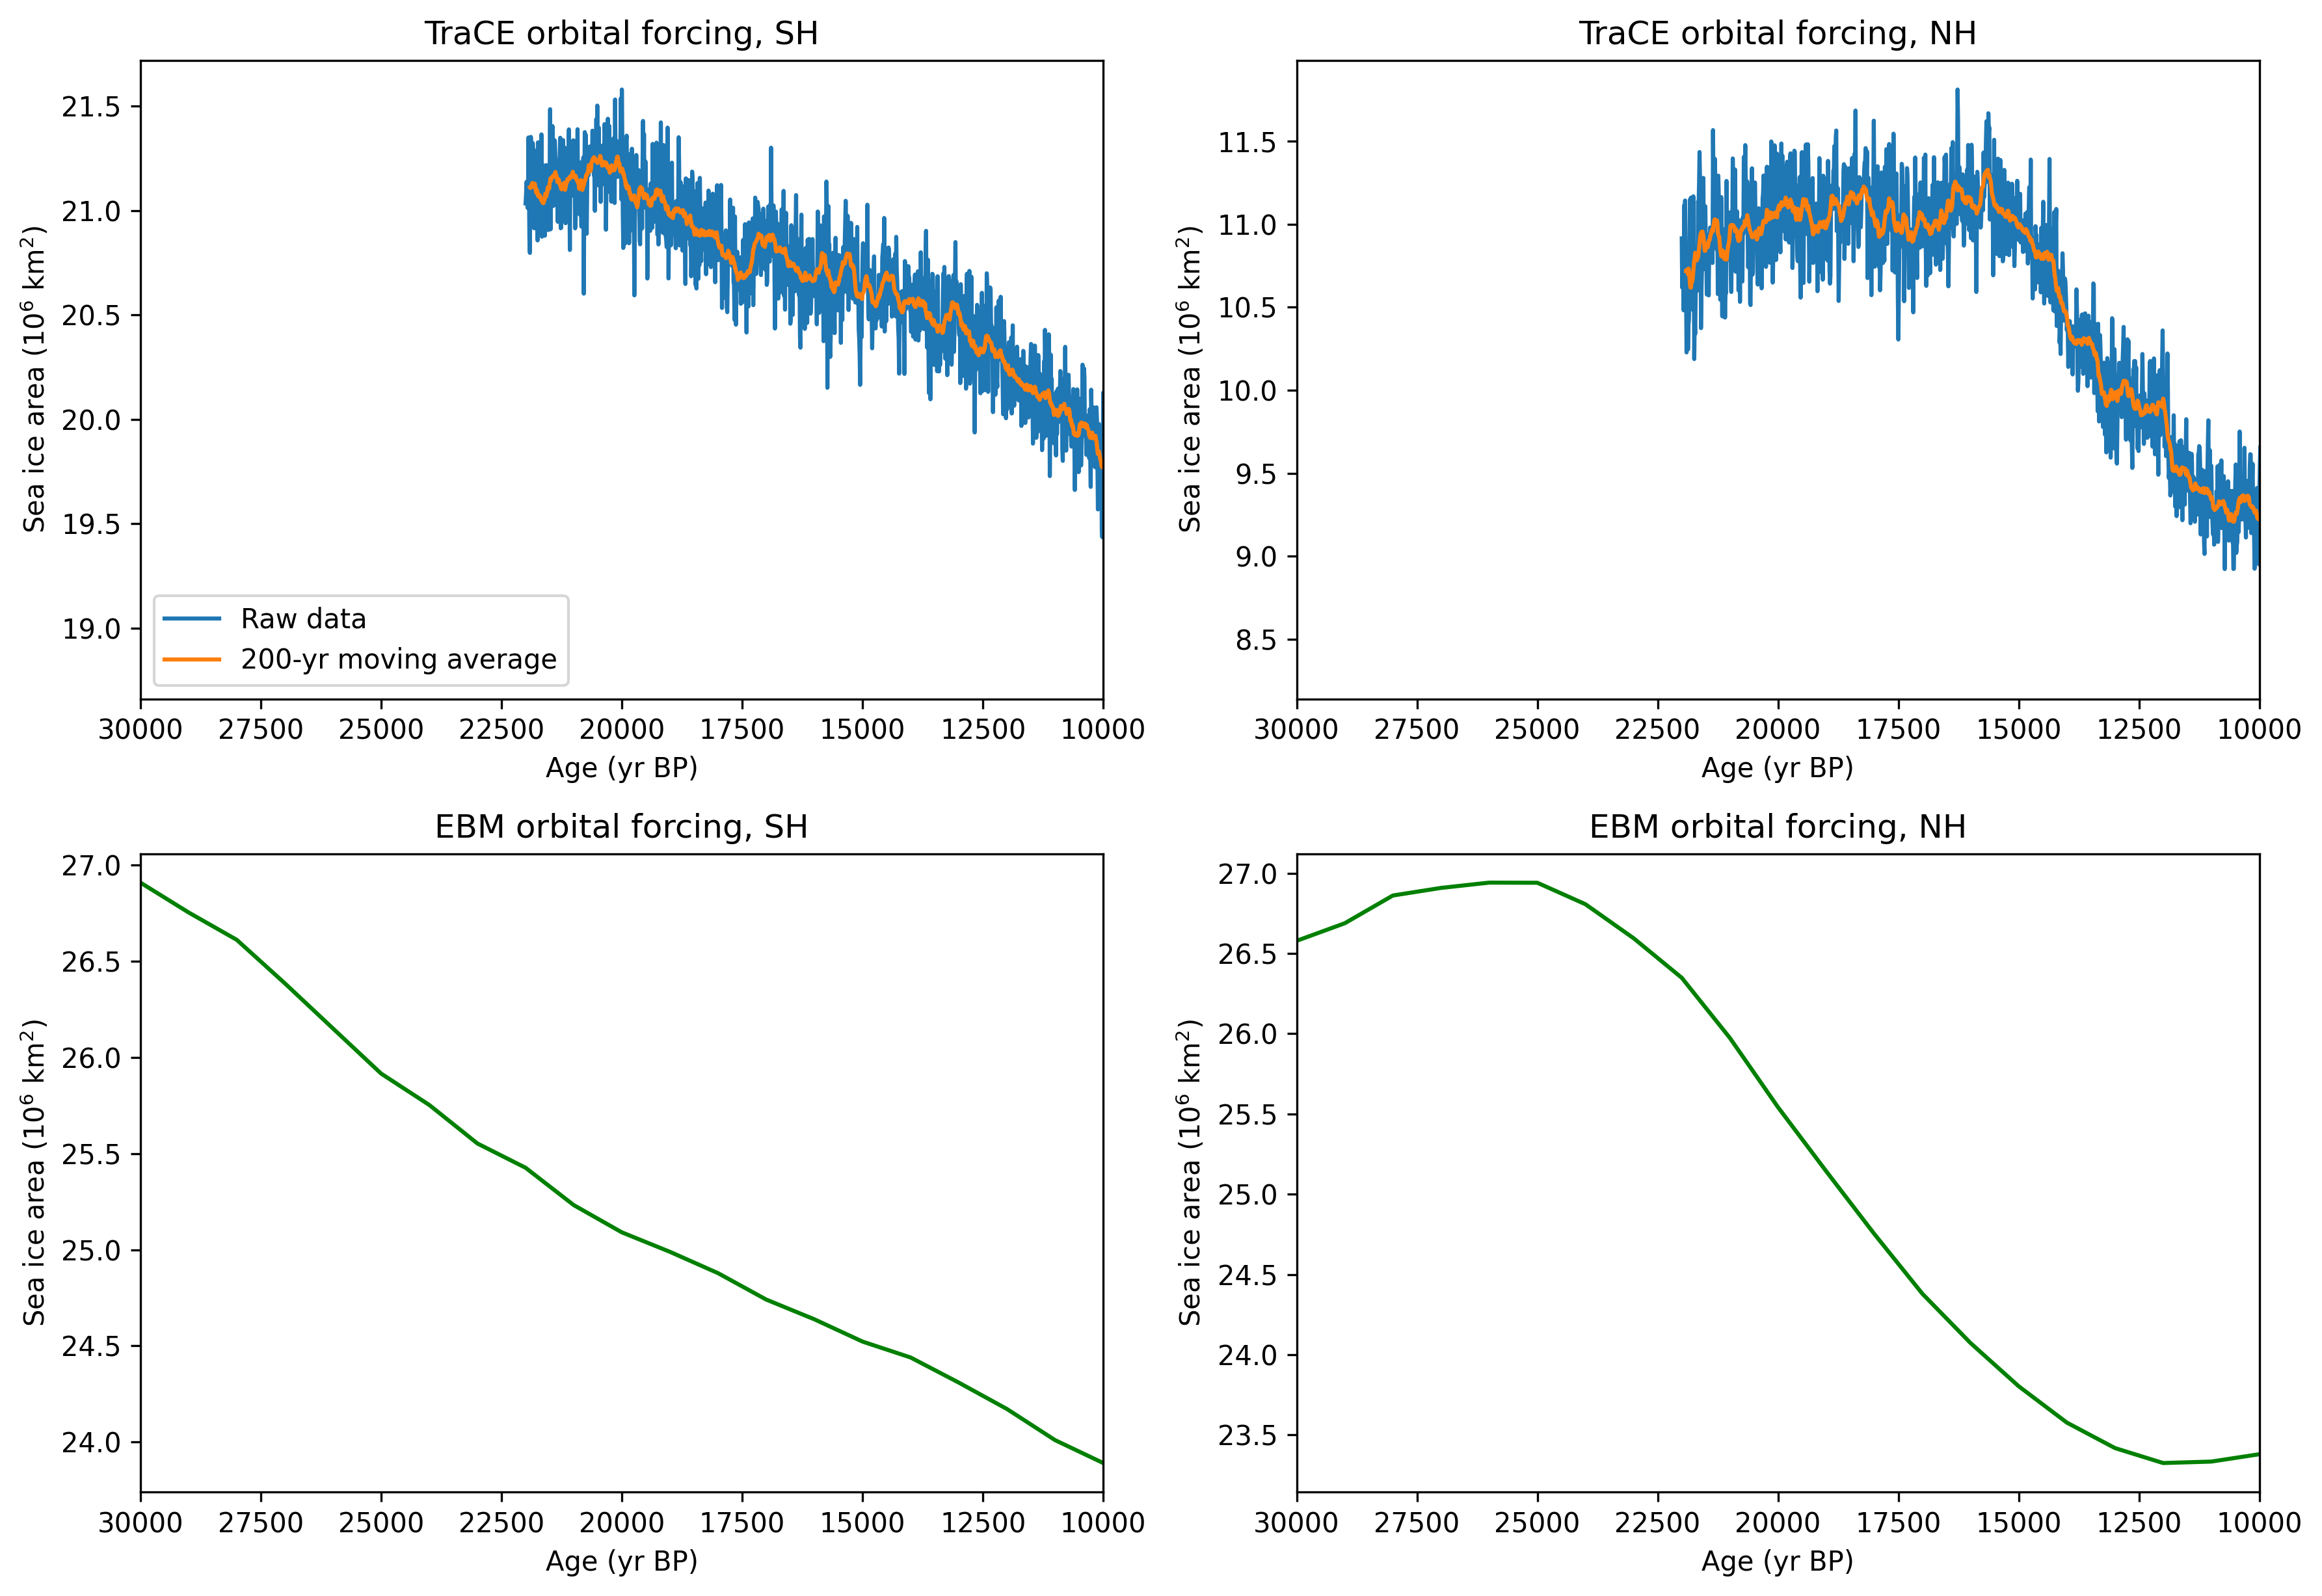

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming asice_trace_orb_sh, asice_trace_orb_nh, df_full_orbital_EBM_sh, df_full_orbital_EBM_nh are defined

# Define a moving average function
def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# Create a 2 by 2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=300)
# fig.suptitle('Sea ice area comparison')

smoothing_len = 20

# Apply the moving average
smoothed_asice_trace_orb_sh = moving_average(asice_trace_orb_sh[:, 1], smoothing_len)
smoothed_asice_trace_orb_nh = moving_average(asice_trace_orb_nh[:, 1], smoothing_len)

# Adjust x-axis data for moving average
adjusted_x_sh = asice_trace_orb_sh[9:-10, 0]
adjusted_x_nh = asice_trace_orb_nh[9:-10, 0]

# Plotting TraCE data

axs[0, 0].plot(asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1], label='Raw data')
axs[0, 0].plot(adjusted_x_sh, smoothed_asice_trace_orb_sh, label='200-yr moving average')
axs[0, 0].set_title('TraCE orbital forcing, SH')
axs[0, 0].set_xlabel('Age (yr BP)')
axs[0, 0].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[0, 0].invert_xaxis()
# legend in lower left
axs[0, 0].legend(loc='lower left')

axs[0, 1].plot(asice_trace_orb_nh[:, 0], asice_trace_orb_nh[:, 1], label='TraCE, raw data')
axs[0, 1].plot(adjusted_x_nh, smoothed_asice_trace_orb_nh, label='TraCE, smoothed')
axs[0, 1].set_title('TraCE orbital forcing, NH')
axs[0, 1].set_xlabel('Age (yr BP)')
axs[0, 1].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[0, 1].invert_xaxis()

# Plotting EBM data
axs[1, 0].plot(df_full_orbital_EBM_sh['age'], df_full_orbital_EBM_sh['iceA (SH)'], label='EBM orbital forcing', color='green')
axs[1, 0].set_title('EBM orbital forcing, SH')
axs[1, 0].set_xlabel('Age (yr BP)')
axs[1, 0].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[1, 0].invert_xaxis()
# legend
# axs[1, 0].legend()

axs[1, 1].plot(df_full_orbital_EBM_nh['age'], df_full_orbital_EBM_nh['iceA (SH)'], label='EBM NH', color='green')
axs[1, 1].set_title('EBM orbital forcing, NH')
axs[1, 1].set_xlabel('Age (yr BP)')
axs[1, 1].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[1, 1].invert_xaxis()

# # Adjusting layout and adding legends
for ax in axs.flat:
    # ax.legend()
    # set x lim
    ax.set_xlim(30000, 10000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
